# **IMAGE CAPTIONING 15/12**

# **IMPORTS**

In [3]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import tensorflow as tf

# Check GPU devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# TensorFlow will attempt to use GPU for computations
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0])
    b = tf.reduce_sum(a)
    print(b)


Num GPUs Available:  1
tf.Tensor(6.0, shape=(), dtype=float32)


In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
image_path = './Flicker8k/Flicker8k_Dataset'

In [5]:
data = pd.read_csv("./Flicker8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


# **OPEN SINGLE IMAGE**

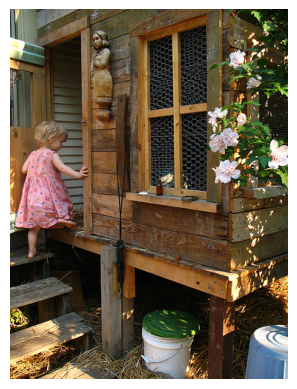

In [5]:
image = image_path + "/1000268201_693b08cb0e.jpg"

from PIL import Image
img = Image.open(image)
plt.imshow(img)
plt.axis('off')  # Hide axes for better visualization
plt.show()

# **VISUALIZATION**

In [9]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"./Flicker8k/Flicker8k_Dataset/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [ ]:
display_images(data.sample(15))

# **Caption Text Preprocessing Steps**

In [6]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [7]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
# captions[:10]

# **TOKENIZATION**

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [14]:


# Define the path to the folder and file
folder_path = './IC Models/1912'
file_path = os.path.join(folder_path, 'tokenizer.pkl')

# Check if the folder exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Created folder: {folder_path}")

# Save the tokenizer
with open('./IC Models/1912/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

Created folder: ./IC Models/1912


In [14]:
import pickle
with open('./IC Models/1912/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)


# **Image Feature Extraction**

In [18]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [12:52<00:00, 10.47it/s]


In [20]:
import pickle

# Save features to a file
with open("./IC Models/1912/features1912.pkl", "wb") as f:
    pickle.dump(features, f)
print("Features saved successfully!")

Features saved successfully!


In [9]:
import pickle
# Load features from the file
with open("./IC Models/1912/features1912.pkl", "rb") as f:
    loaded_features = pickle.load(f)
print("Features loaded successfully!")

Features loaded successfully!


In [ ]:
if pickle.dumps(features) == pickle.dumps(loaded_features):
    print("Features match!")
else:
    print("Features do not match!")

In [10]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [11]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
from tensorflow.keras.utils import plot_model

# Save the model architecture to a file
plot_model(caption_model, to_file='caption_model.png', show_shapes=True, show_layer_names=True)

print("Model diagram saved as 'caption_model.png'.")

In [ ]:
caption_model.summary()

In [24]:
my_batch_size=64
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=my_batch_size,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=loaded_features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=my_batch_size,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=loaded_features)

In [26]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=2,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [27]:
history = caption_model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/30
537/537 [==============================] - ETA: 0s - loss: 3.1849
Epoch 1: val_loss improved from inf to 3.65214, saving model to model.keras
537/537 [==============================] - 83s 154ms/step - loss: 3.1849 - val_loss: 3.6521 - lr: 8.0000e-06
Epoch 2/30
537/537 [==============================] - ETA: 0s - loss: 3.1818
Epoch 2: val_loss improved from 3.65214 to 3.64443, saving model to model.keras
537/537 [==============================] - 27s 50ms/step - loss: 3.1818 - val_loss: 3.6444 - lr: 8.0000e-06
Epoch 3/30
536/537 [============================>.] - ETA: 0s - loss: 3.1824
Epoch 3: val_loss did not improve from 3.64443
537/537 [==============================] - 28s 52ms/step - loss: 3.1826 - val_loss: 3.6522 - lr: 8.0000e-06
Epoch 4/30
536/537 [============================>.] - ETA: 0s - loss: 3.1813
Epoch 4: val_loss did not improve from 3.64443

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
537/537 [==============================

In [2]:
import gc
gc.collect()

0

In [21]:
caption_model.save('./IC Models/1912/caption_model_32b.h5')
caption_model.save('./IC Models/1912/caption_model_32b.keras')

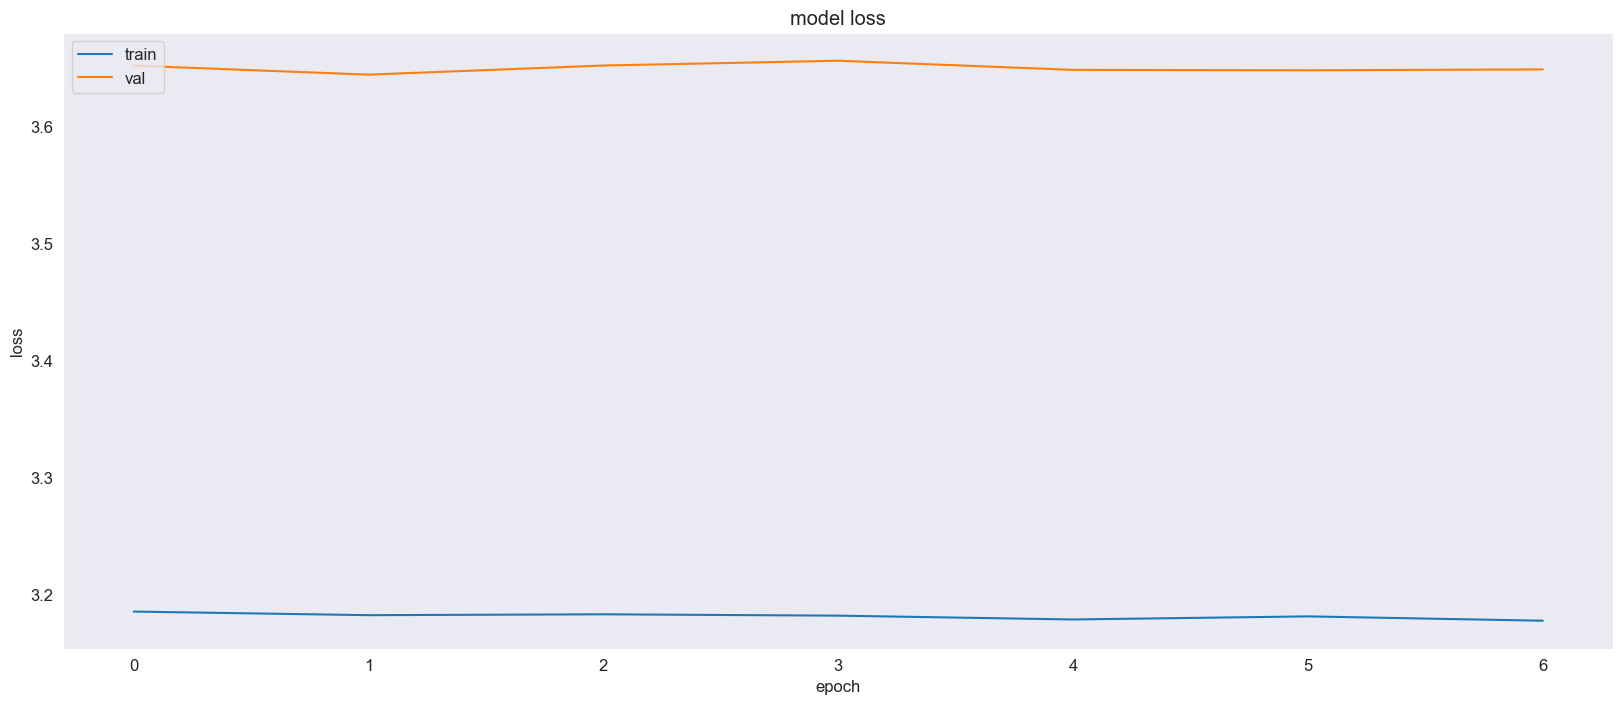

In [28]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Caption Generation Utility Functions**

In [23]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [24]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [25]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [27]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, loaded_features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 16ms/step


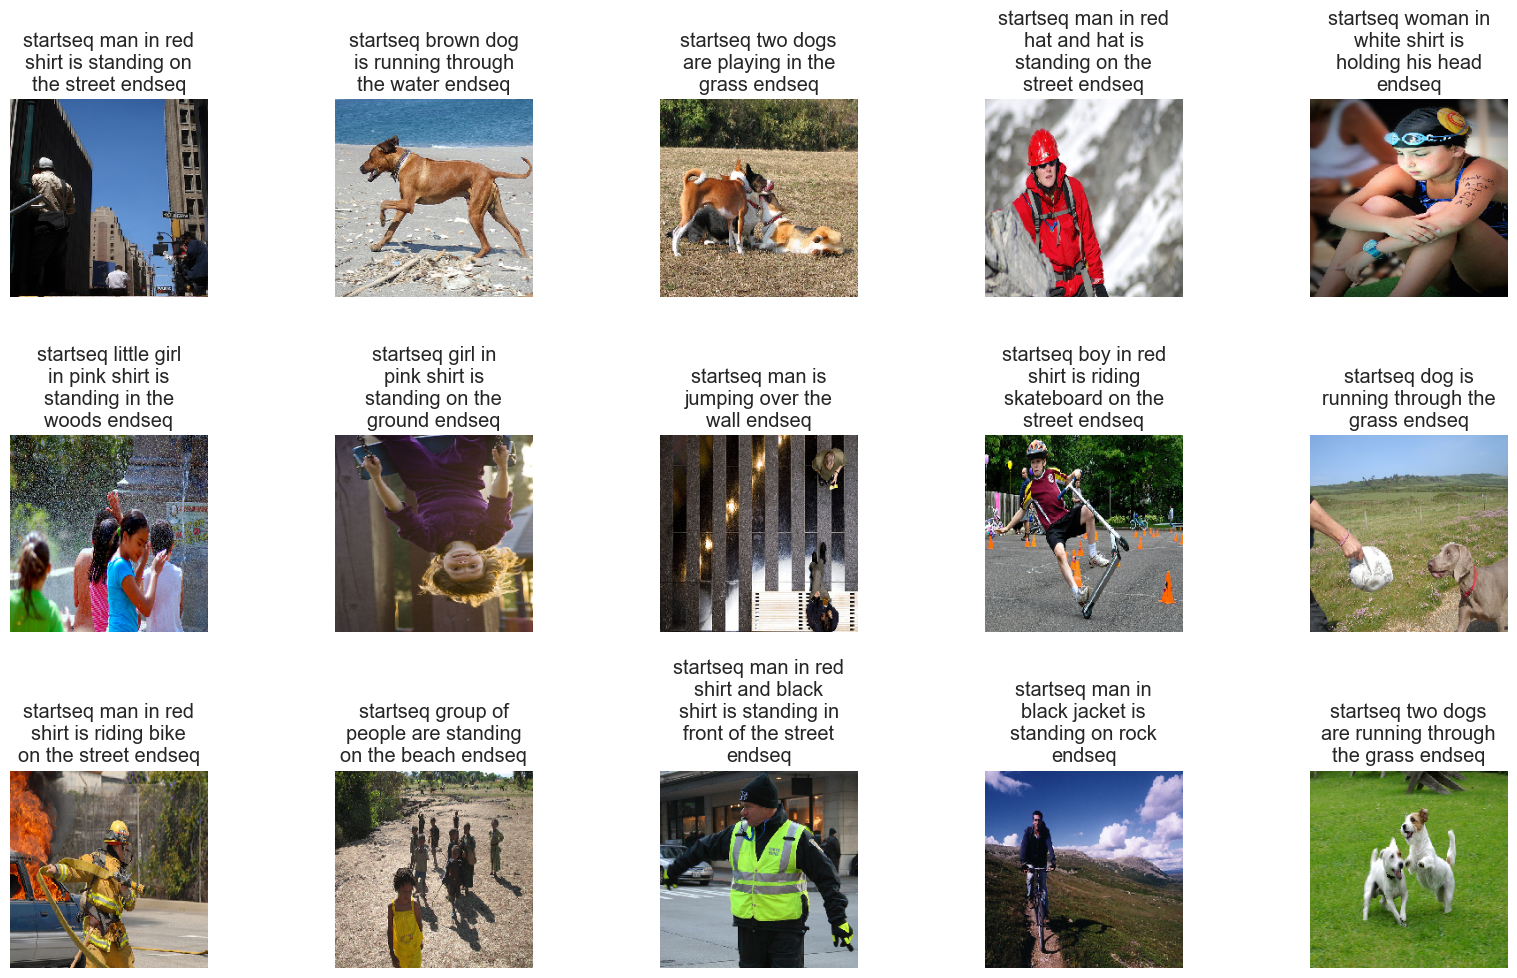

In [28]:
display_images(samples)